<a href="https://colab.research.google.com/github/sfc1keigo/lecture3/blob/main/%E7%94%BB%E5%83%8F%E8%AA%8D%E8%AD%98_Pytorch%E6%B7%B1%E5%B1%A4%E5%AD%A6%E7%BF%92%E7%94%A8%E3%83%97%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%9F%E3%83%B3%E3%82%B0%E3%82%88%E3%82%8A%E5%BC%95%E7%94%A812%E7%AB%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# カスタムデータによる画像認識

In [13]:
# 必要ライブラリ・コマンドの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
w = !apt install tree
print(w[-2])

Use 'apt autoremove' to remove it.


In [14]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

In [15]:
# PyTorch関連ライブラリのインポート

import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [16]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [17]:
# GPUチェック

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### 共通関数の読み込み

In [18]:
# 共通関数のダウンロード
!git clone https://github.com/makaishi2/pythonlibs.git

# 共通関数のロード
from pythonlibs.torch_lib1 import *

# 共通関数の存在チェック
print(README)

fatal: destination path 'pythonlibs' already exists and is not an empty directory.
Common Library for PyTorch
Author: M. Akaishi


## データ準備

### サンプルデータのダウンロード・解凍

In [19]:
# サンプルデータのダウンロード
w = !wget -nc https://download.pytorch.org/tutorial/hymenoptera_data.zip

# 結果確認
print(w[-2])

File ‘hymenoptera_data.zip’ already there; not retrieving.


In [20]:
# データ解凍
w = !unzip -o hymenoptera_data.zip

# 結果確認
print(w[-1])

  inflating: hymenoptera_data/val/bees/abeja.jpg  


In [9]:
# 解凍ファイルのtree表示
!tree hymenoptera_data

hymenoptera_data
├── train
│   ├── ants
│   │   ├── 0013035.jpg
│   │   ├── 1030023514_aad5c608f9.jpg
│   │   ├── 1095476100_3906d8afde.jpg
│   │   ├── 1099452230_d1949d3250.jpg
│   │   ├── 116570827_e9c126745d.jpg
│   │   ├── 1225872729_6f0856588f.jpg
│   │   ├── 1262877379_64fcada201.jpg
│   │   ├── 1269756697_0bce92cdab.jpg
│   │   ├── 1286984635_5119e80de1.jpg
│   │   ├── 132478121_2a430adea2.jpg
│   │   ├── 1360291657_dc248c5eea.jpg
│   │   ├── 1368913450_e146e2fb6d.jpg
│   │   ├── 1473187633_63ccaacea6.jpg
│   │   ├── 148715752_302c84f5a4.jpg
│   │   ├── 1489674356_09d48dde0a.jpg
│   │   ├── 149244013_c529578289.jpg
│   │   ├── 150801003_3390b73135.jpg
│   │   ├── 150801171_cd86f17ed8.jpg
│   │   ├── 154124431_65460430f2.jpg
│   │   ├── 162603798_40b51f1654.jpg
│   │   ├── 1660097129_384bf54490.jpg
│   │   ├── 167890289_dd5ba923f3.jpg
│   │   ├── 1693954099_46d4c20605.jpg
│   │   ├── 175998972.jpg
│   │   ├── 178538489_bec7649292.jpg
│   │   ├── 1804095607_0341701e1c.jpg
│   │   

### Transforms定義

In [21]:
# Transforms定義

# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

### データセット定義

In [22]:
# ツリーのベースディレクトリ
data_dir = 'hymenoptera_data'

# 訓練データディレクトリと検証データディレクトリの指定
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

# join関数の結果確認
print(train_dir, test_dir)

# 分類先クラスのリスト作成
classes = ['ants', 'bees']

hymenoptera_data/train hymenoptera_data/val


In [23]:
# データセット定義

# 訓練用
train_data = datasets.ImageFolder(train_dir, 
            transform=train_transform)
# 訓練データのイメージ表示用
train_data2 = datasets.ImageFolder(train_dir, 
            transform=test_transform)
# 検証用
test_data = datasets.ImageFolder(test_dir, 
            transform=test_transform)

In [24]:
# データ件数確認

print(f'訓練データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

訓練データ: 244件
検証データ: 153件


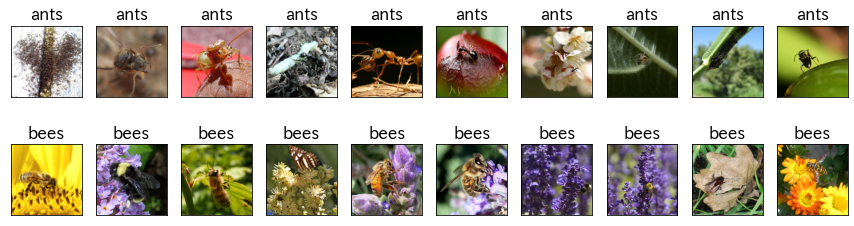

In [25]:
# 検証データ　
# 最初の10個と最後の10個の表示

plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    image, label = test_data[i]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 11)
    image, label = test_data[-i-1]
    img = (np.transpose(image.numpy(), (1, 2, 0)) + 1)/2
    plt.imshow(img)
    ax.set_title(classes[label])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### データローダー定義

In [26]:
# データローダー定義

batch_size = 10

# 訓練用
train_loader = DataLoader(train_data, 
      batch_size=batch_size, shuffle=True)

# 検証用
test_loader = DataLoader(test_data, 
      batch_size=batch_size, shuffle=False)

# イメージ表示用
train_loader2 = DataLoader(train_data2, 
      batch_size=50, shuffle=True)
test_loader2 = DataLoader(test_data, 
      batch_size=50, shuffle=True)

### イメージ表示

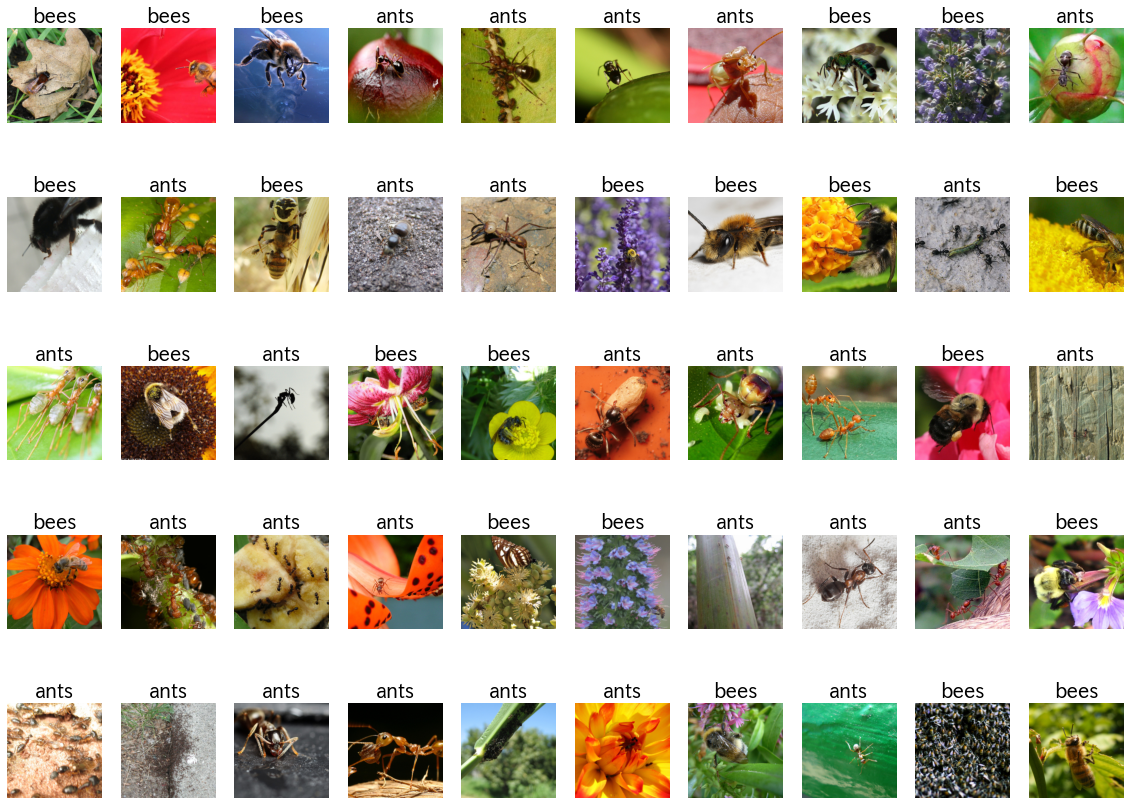

In [27]:
# 検証用データ(50件)
torch_seed()
show_images_labels(test_loader2, classes, None, None)

## ファインチューニング版

In [28]:
# ファインチューニング版

# 学習済みモデルの読み込み
# vgg19_bnをパラメータ付きで読み込む
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
optimizer = optim.SGD(net.parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
# 学習
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, 
          train_loader, test_loader, device, history)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/5], loss: 0.04431 acc: 0.81557 val_loss: 0.01113, val_acc: 0.96078


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/5], loss: 0.02735 acc: 0.86066 val_loss: 0.01192, val_acc: 0.96732


  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
# 結果確認
evaluate_history(history)

In [ ]:
# 乱数初期化
torch_seed()

# 検証データへの結果表示
show_images_labels(test_loader2, classes, net, device)


## 転移学習版

In [ ]:
# vgg19_bnをパラメータ付きで読み込む
from torchvision import models
net = models.vgg19_bn(pretrained = True)

# すべてのパラメータで勾配計算なしに
for param in net.parameters():
    param.requires_grad = False

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
# このノードのみ勾配計算をすることになる
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

# 学習率
lr = 0.001

# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
# パラメータ修正の対象を最終ノードに限定
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [ ]:
# 学習
num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, 
          train_loader, test_loader, device, history)

In [ ]:
# 結果サマリー
evaluate_history(history)

In [ ]:
# 乱数初期化
torch_seed()

# 検証データへの結果表示
show_images_labels(test_loader2, classes, net, device)

## ユーザー定義データの場合 
シベリアンハスキーとオオカミの画像を利用  
ダウンロード元  
https://pixabay.com/ja/ 

### データダウンロード・解凍

In [ ]:
# データダウンロード
w = !wget https://github.com/makaishi2/pythonlibs/raw/main/images/dog_wolf.zip
print(w[-2])

# 解凍
!unzip dog_wolf.zip | tail -n 1

# 解凍結果のツリー表示
!tree dog_wolf

### Transforms定義

In [ ]:
# Transforms定義

# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)   
])

### データセット定義

In [ ]:
# データセット定義

data_dir = 'dog_wolf'

import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

classes = ['dog', 'wolf']

train_data = datasets.ImageFolder(train_dir, 
            transform=train_transform)
train_data2 = datasets.ImageFolder(train_dir, 
            transform=test_transform)
test_data = datasets.ImageFolder(test_dir, 
            transform=test_transform)


In [ ]:
# データ件数確認

print(f'学習データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

### データローダー定義

In [ ]:
# データローダー定義

batch_size = 5
# 学習データ
train_loader = DataLoader(train_data, 
            batch_size=batch_size, shuffle=True)
# 学習データ　イメージ表示用
train_loader2 = DataLoader(train_data2, 
            batch_size=40, shuffle=False)
# 検証データ
test_loader = DataLoader(test_data, 
            batch_size=batch_size, shuffle=False)
# 検証データ　イメージ表示用
test_loader2 = DataLoader(test_data, 
            batch_size=10, shuffle=True)

### イメージ表示

In [ ]:
# 訓練用データ(４0件)
show_images_labels(train_loader2, classes, None, None)

In [ ]:
# 検証用データ(10件)
torch_seed()
show_images_labels(test_loader2, classes, None, None)

### モデル定義 (転移学習)

In [ ]:
# 学習済みモデルの読み込み
net = models.vgg19_bn(pretrained = True)

for param in net.parameters():
    param.requires_grad = False

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

lr = 0.001
# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
# パラメータ修正の対象を最終ノードに限定
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))